In [ ]:
# | hide
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

# Tidy Tensors


In [ ]:
# | default_exp tensor

In [ ]:
# | export
import numpy as np

In [ ]:
# | exporti
def calculate_target_shape(s1, s2):
    """Calculate the target shape for broadcasting two tensors"""

    # expand shaped to be the same length. Note (1,) * <negative> is empty
    s2 = (1,) * (len(s1) - len(s2)) + s2
    s1 = (1,) * (len(s2) - len(s1)) + s1

    out_shape = ()
    for dims in list(zip(reversed(s1), reversed(s2))):
        if dims[0] != 1 and dims[1] != 1 and dims[0] != dims[1]:
            raise ValueError(f"Cannot broadcast {s1} and {s2}")
        out_shape = (max(dims),) + out_shape

    return out_shape

In [ ]:
# | exporti


def maybe_broadcast_elementwise(a, b):
    """Broadcast two tensors if they have different shapes"""
    if a.data.shape != b.data.shape:
        target_shape = calculate_target_shape(a.data.shape, b.data.shape)
        # print(
        #     f"Elementwise broadcasted {a.data.shape} and {b.data.shape} to {target_shape}"
        # )
        a = a.broadcast(target_shape)
        b = b.broadcast(target_shape)

    return a, b


def maybe_broadcast_matmul(a, b):
    """Broadcast two tensors if they have different shapes, except for the last two dimensions"""

    a_short_shape = a.data.shape[:-2]
    b_short_shape = b.data.shape[:-2]

    if a_short_shape != b_short_shape:
        target_shape = calculate_target_shape(a_short_shape, b_short_shape)
        print(
            f"Matmul broadcasted {a.data.shape} and {b.data.shape} to {target_shape + a.data.shape[-2:]}"
        )
        a = a.broadcast(target_shape + a.data.shape[-2:])
        b = b.broadcast(target_shape + b.data.shape[-2:])

    return a, b

In [ ]:
# | export


class Tensor:
    op = "L"
    name: str = ""
    parents: list = []
    eps = 1e-10

    def __init__(self, data, name="", eps=1e-8):
        if not isinstance(data, np.ndarray):
            data = np.array(data)

        self.data = data
        self.name = name
        self.grad = np.zeros_like(self.data)
        self.eps = eps

    def broadcast(self, target_shape):
        self_shape = self.data.shape
        if self_shape == target_shape:
            return self

        if len(self_shape) < len(target_shape):
            expanded_shape = (len(target_shape) - len(self_shape)) * (1,) + self_shape
        else:
            expanded_shape = self_shape

        final_shape = ()
        broadcasted_dims = ()

        for s_expanded, s_target in reversed(list(zip(expanded_shape, target_shape))):
            if s_expanded != s_target:
                if s_expanded != 1:
                    raise ValueError(f"Cannot broadcast {self_shape} to {target_shape}")
                else:
                    broadcasted_dims = (True,) + broadcasted_dims
                    final_shape = (s_target,) + final_shape

            else:
                broadcasted_dims = (False,) + broadcasted_dims
                final_shape = (s_expanded,) + final_shape

        broadcasted_data = np.broadcast_to(self.data, final_shape)

        assert final_shape == broadcasted_data.shape

        out = BroadcastTensor(data=broadcasted_data, name=self.name + "_broadcasted")
        out.parents = [self]
        out.broadcasted_dims = broadcasted_dims
        return out

    # Elementwise operations
    def add(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)

        out = AddTensor(data=a.data + b.data, name=name)
        out.parents = [a, b]
        return out

    def sub(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)
        out = SubTensor(data=a.data - b.data, name=name)
        out.parents = [a, b]
        return out

    def neg(self, name="Noname"):
        zero_tensor = Tensor(data=np.zeros_like(self.data), name="zero")
        out = zero_tensor.sub(self, name)
        out.parents = [zero_tensor, self]
        return out

    def mul(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)
        out = MulTensor(data=a.data * b.data, name=name)
        out.parents = [a, b]
        return out

    def log(self, name="Noname"):
        # data = self.data
        # print(f"min/max of data is {data.min()}/{data.max()}")
        # print(f"min/max of res is {np.log(data).min()}/{np.log(data).max()}")
        # print(f"Log of:\n{data}\nis:{np.log(data)}")

        out = LogTensor(data=np.log(self.data), name=name)
        out.parents = [self]
        return out

    def sigmoid(self, name="Noname"):
        out = SigmoidTensor(data=1 / (1 + np.exp(-self.data)), name=name)
        out.parents = [self]
        return out

    def relu(self, name="Noname"):
        out = ReluTensor(data=np.maximum(0, self.data), name=name)
        out.parents = [self]
        return out

    # Matrix operations
    def mmul(self, other, name="Noname"):
        a, b = maybe_broadcast_matmul(self, other)
        # a, b = self, other
        out = MatMulTensor(data=np.matmul(a.data, b.data), name=name)
        out.parents = [a, b]
        return out

    # Reduction operations
    def sum(self, name="Noname"):
        out = SumTensor(data=self.data.sum(), name=name)
        out.parents = [self]
        return out

    def backward(self):
        # Create a list of all parent nodes, in reverse order
        # Start with the current node
        visited = []
        nodes = []

        assert self.data.size == 1, "Cannot call backward on non-scalar tensor"

        def walk(node):
            for p in node.parents:
                if p not in visited:
                    visited.append(p)
                    walk(p)
                    nodes.append(p)

        walk(self)
        nodes.append(self)

        # print(nodes)
        self.grad = np.ones_like(self.data)
        for n in nodes[::-1]:
            if hasattr(n, "_backward"):
                n._backward()

    def __repr__(self):
        value_repr = repr(self.data)
        if "\n" in value_repr:
            res = f"\n{self.name}=\n{str(self.data)}\n{self.name}.grad=\n{str(self.grad)}"
        else:
            res = f"{self.name}={str(self.data)} {self.name}.grad={str(self.grad)}"

        if self.parents:
            res += (
                f" {self.name}.parents=[" + ",".join([p.name for p in self.parents]) + "]"
            )

        return f"Tensor(shape=[{self.data.shape}])] op={self.op or ''} {res}"


class AddTensor(Tensor):
    op = "+"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad += self.grad


class SubTensor(Tensor):
    op = "-"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad -= self.grad


class MulTensor(Tensor):
    op = "*"

    def _backward(self):
        self.parents[0].grad += self.grad * self.parents[1].data
        self.parents[1].grad += self.grad * self.parents[0].data


class MatMulTensor(Tensor):
    op = "@"

    def _backward(self):
        # print(self.grad)
        self.parents[0].grad += np.matmul(self.grad, self.parents[1].data.T)
        self.parents[1].grad += np.matmul(self.parents[0].data.T, self.grad)


class SumTensor(Tensor):
    op = "sum"

    def _backward(self):
        self.parents[0].grad += self.grad


class SigmoidTensor(Tensor):
    op = "sigmoid"

    def _backward(self):
        self.parents[0].grad += self.grad * self.data * (1 - self.data)


class ReluTensor(Tensor):
    op = "relu"

    def _backward(self):
        self.parents[0].grad += self.grad * (self.data > 0)


class LogTensor(Tensor):
    op = "log"

    def _backward(self):
        self.parents[0].grad += self.grad * (1.0 / (self.parents[0].data))


class BroadcastTensor(Tensor):
    op = "broadcast"

    def _backward(self):
        axis = tuple([i for i, dim in enumerate(self.broadcasted_dims) if dim])
        summed = self.grad.sum(axis=axis, keepdims=True)

        if summed.shape != self.parents[0].data.shape:
            summed = summed.reshape(self.parents[0].data.shape)

        self.parents[0].grad += summed

In [ ]:
from fastcore.test import test_eq, test_fail

In [ ]:
test_eq(calculate_target_shape((1, 2, 3), (2, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (2, 1)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 1)), (1, 2, 3))

test_eq(calculate_target_shape((1, 5), (3, 1)), (3, 5))

test_fail(calculate_target_shape, args=((1, 2, 3), (2, 2)), contains="Cannot broadcast")

In [ ]:
import matplotlib.pyplot as plt

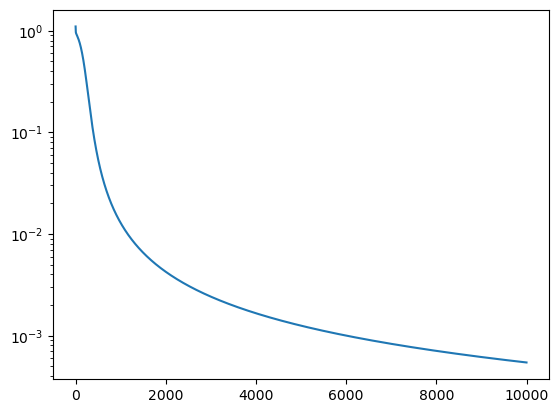

In [ ]:
# Train an XOR network
X = [
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]


Y = [0, 1, 1, 0]


np.random.seed(1337)

w1 = Tensor(np.random.randn(2, 6), "w1")
b1 = Tensor(np.zeros((1, 6)), "b1")

w2 = Tensor(np.random.randn(6, 1), "w2")

LR = 0.3

losses = []


def NN(inputs, params):
    x, y = inputs
    w1, b1, w2 = params
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
    preds = z1.mmul(w2, "z2").sigmoid("preds")

    diff = preds.sub(y, "diff")

    l = diff.mul(diff, "l")
    loss = l.sum("loss")

    return loss


for i in range(10000):
    x = Tensor(np.array(X, dtype=float), "x")
    y = Tensor(np.array(Y, dtype=float)[:, None], "y")

    loss = NN((x, y), (w1, b1, w2))

    loss.backward()

    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)

    losses.append(loss.data)

plt.plot(losses)
plt.yscale("log")

In [ ]:
test_eq(loss.data < 0.01, True)

In [ ]:
import os
import numpy as np
import requests
from lovely_numpy import Lo

In [ ]:
# | eval: false

def download_file(url, path):
    dir_path = os.path.dirname(path)

    os.makedirs(dir_path, exist_ok=True)
    if not os.path.exists(path):
        response = requests.get(url)
        with open(path, "wb") as f:
            f.write(response.content)


def load_mnist(path="../datasets/d/d/ddd/"):
    download_file(
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz",
        os.path.join(path, "mnist.npz"),
    )
    with np.load(os.path.join(path, "mnist.npz")) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]
    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

tt = Lo(x_train[0] / 255).chans(scale=10)

In [ ]:
# | eval: false

LR = 0.01
BS = 32

INT_DIM = 128


w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def MM(inputs, params, debug=list()):
    x, y = inputs
    w1, b1, w2 = params
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
    z2 = z1.mmul(w2, "z2")

    preds = z2.sigmoid("preds")

    return preds


def MM_with_loss(inputs, params, debug=list()):
    x, y = inputs

    preds = MM(inputs, params, debug=debug)

    ones = Tensor(np.ones_like(preds.data), "ones")
    loss_1 = y.mul(preds.log(), "loss_1")
    loss_2 = ones.sub(y).mul(ones.sub(preds, "loss_2").log())
    loss = loss_1.add(loss_2, "loss").sum().neg("loss")
    loss = loss.mul(Tensor(np.array(1 / x.data.shape[0])), "loss")
    return loss


idxs = np.random.choice(len(x_train), BS, replace=False)
x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255, "x")
y_np = y_train[idxs][:, None]
y_np = np.eye(10)[y_np.reshape(-1)]  # one-hot encode y

y = Tensor(y_np.astype(float), "y")

debug = []

loss = MM_with_loss((x, y), (w1, b1, w2), debug=[])
loss.backward()

# print(b1, *debug)

# Grad check does not work because of the exp/log numerical instability
# grad_check(MM, (x, y), (w1, b1, w2), eps=1e-5)

In [ ]:
# | eval: false
np.seterr(all="warn")

# over-fitting on 1 batch

metrics = {
    "loss" : [],
    "acc" : [],
    "val_loss" : [],
    "val_acc" : [],
    "iter": [],
}

avg_loss = 0
n_accum = 0
for i in range(1,10000):    
    n_accum += 1
    idxs = np.random.choice(len(x_train), BS, replace=False)
    x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255 - 0.5, "x")
    y_np = y_train[idxs][:, None]
    y_np = np.eye(10)[y_np.reshape(-1)]

    y = Tensor(y_np.astype(float), "y")

    # One-hot encoding y

    debug = []
    loss = MM_with_loss((x, y), (w1, b1, w2), debug)
    # (z1, z2, preds, diff, l) = debug

    loss.backward()

    if np.isnan(w1.grad).any() or np.isnan(b1.grad).any() or np.isnan(w2.grad).any():
        w1.grad = np.zeros_like(w1.grad)
        b1.grad = np.zeros_like(b1.grad)
        w2.grad = np.zeros_like(w2.grad)
    
    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad
    # b2.data -= LR * b2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)
    # b2.grad = np.zeros_like(b2.grad)
    avg_loss += loss.data
    
    
    if i % 1000 == 0:
        avg_loss /= n_accum

        preds = MM((x, y), (w1, b1, w2))
        accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))

    
        x = Tensor(x_test.reshape(len(x_test), 28 * 28) / 255 - 0.5, "x")
        y_np = y_test[:, None]
        y_np = np.eye(10)[y_np.reshape(-1)]
        y = Tensor(y_np.astype(float), "y")

        preds = MM((x, y), (w1, b1, w2))
        val_loss = MM_with_loss((x, y), (w1, b1, w2))
        val_accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))
        print(f"Loss: {avg_loss:.2f} Accuracy: {accuracy:.2f} Val Loss: {loss.data} Val Accuracy: {val_accuracy:.2f}")
        metrics["loss"].append(avg_loss)
        metrics["acc"].append(accuracy)
        metrics["val_loss"].append(val_loss.data)
        metrics["val_acc"].append(val_accuracy)
        metrics["iter"].append(i)

        avg_loss = 0



Loss: 4.46 Accuracy: 0.38 Val Loss: 3.1767103572687816 Val Accuracy: 0.46
Loss: 1.31 Accuracy: 0.66 Val Loss: 2.3306306479198406 Val Accuracy: 0.60
Loss: 0.72 Accuracy: 0.66 Val Loss: 1.8842535151615043 Val Accuracy: 0.66
Loss: 0.47 Accuracy: 0.72 Val Loss: 1.8166482904584877 Val Accuracy: 0.70
Loss: 0.34 Accuracy: 0.69 Val Loss: 1.9606423238325483 Val Accuracy: 0.72
Loss: 0.27 Accuracy: 0.78 Val Loss: 1.6026675068265273 Val Accuracy: 0.75
Loss: 0.21 Accuracy: 0.72 Val Loss: 1.3607368994497955 Val Accuracy: 0.76
Loss: 0.18 Accuracy: 0.78 Val Loss: 1.5650116436688144 Val Accuracy: 0.77
Loss: 0.15 Accuracy: 0.81 Val Loss: 1.2666149389936128 Val Accuracy: 0.79


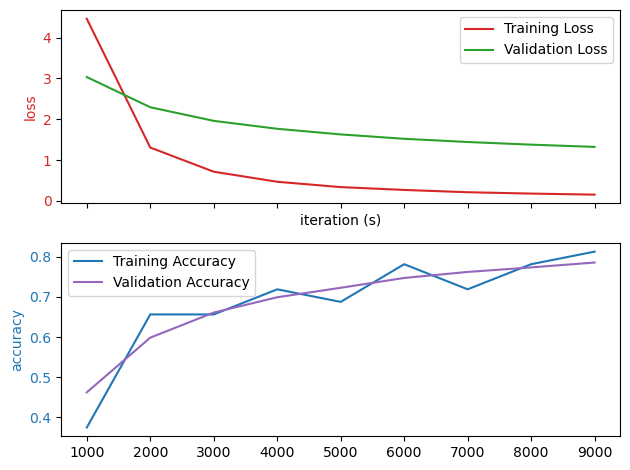

In [ ]:
# | eval: false

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

color = 'tab:red'
ax1.set_xlabel('iteration (s)')
ax1.set_ylabel('loss', color=color)
ax1.plot(metrics["iter"], metrics["loss"], color=color, label='Training Loss')
ax1.plot(metrics["iter"], metrics["val_loss"], color='tab:green', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(metrics["iter"], metrics["acc"], color=color, label='Training Accuracy')
ax2.plot(metrics["iter"], metrics["val_acc"], color='tab:purple', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()